In [2]:
using DelimitedFiles
using CairoMakie
using DelayEmbeddings
using DynamicalSystemsBase

include("../../Modules/TestingFunctions.jl")
using .TestingFunctions

In [3]:
init_conds = [-15.0,-15.0,10.0]
lo_variables = [10, 8/3, 28]
init_time_to_ignore = 10
total_time = 500#s*5
time_delta = 0.01

function Lorenz(u, p, t)
    σ = p[1]
    β = p[2]
    ρ = p[3]

    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]

    return SVector(du1, du2, du3)
end

lo = CoupledODEs(Lorenz, init_conds, lo_variables)
lo_tr, tvec = trajectory(lo, total_time; Δt = time_delta, Ttr = init_time_to_ignore)

function SplitSet(set, ratio)
    split_point = trunc(Int, ratio*length(set))
    train_set = set[1:split_point]
    test_set = set[split_point+1:length(set)]
    
    return(train_set, test_set)
end

lo_tr_train, lo_tr_test = SplitSet(lo_tr, 0.8)
lo_train = lo_tr_train[:,1]
lo_test  = lo_tr_test[:,1]

10001-element Vector{Float64}:
  8.922748372508533
  9.586009034919861
 10.273195090042432
 10.97668024809678
 11.686397398425648
 12.38960052200712
 13.070872103056807
 13.712259255105534
 14.293856525290273
 14.794567150521175
  ⋮
 -5.6174386893258275
 -5.403714341224743
 -5.215558492412537
 -5.0527320746766256
 -4.914823043566489
 -4.80130115491526
 -4.711555893379499
 -4.6449454375949015
 -4.600820630976283

In [4]:
testing_params = create_testing_params()

TestingParameters(false, false, false, false)

[11.221347411415811, 2.0611313081972127, 5.325663350345913, 5.656302698741914, 4.161154137005379, -1.6925433564621915, -6.8533449489573695, 4.85205370791101, 1.601903077886712, -3.8438303140947783, 15.598136922736334, -0.9273538731325593, -4.237348361270317, -2.767770211778242, -4.908576595995295, -1.177335014721352, 2.2768079645856747, -0.2423459752061228, -5.416923611811906, 0.15988355901477802, 4.935754011632567, 8.958938543838931, 3.4411285362357424, -6.6718147886530454, 5.8309249789813675, 4.507487765460855, 7.471490913815327, -1.2129703462923216, 2.9196926361416193, -13.186158645692561, -0.9944519979097056, 21.469403346876394, 14.028041473692568, -7.795492637631434, 4.3773507027057, 2.6131720068765127, 3.4080857201585526, -0.07324710950430711, -1.4928261655442812, -0.5900773367619262, 2.793970217062073, -1.726256803047891, -0.17311684950136874, 2.2801754224707866, 11.633902779449528, -3.4829709367805974, 2.820133782897219, 5.2514610726778175, -5.814205028494621, 8.400277057146399

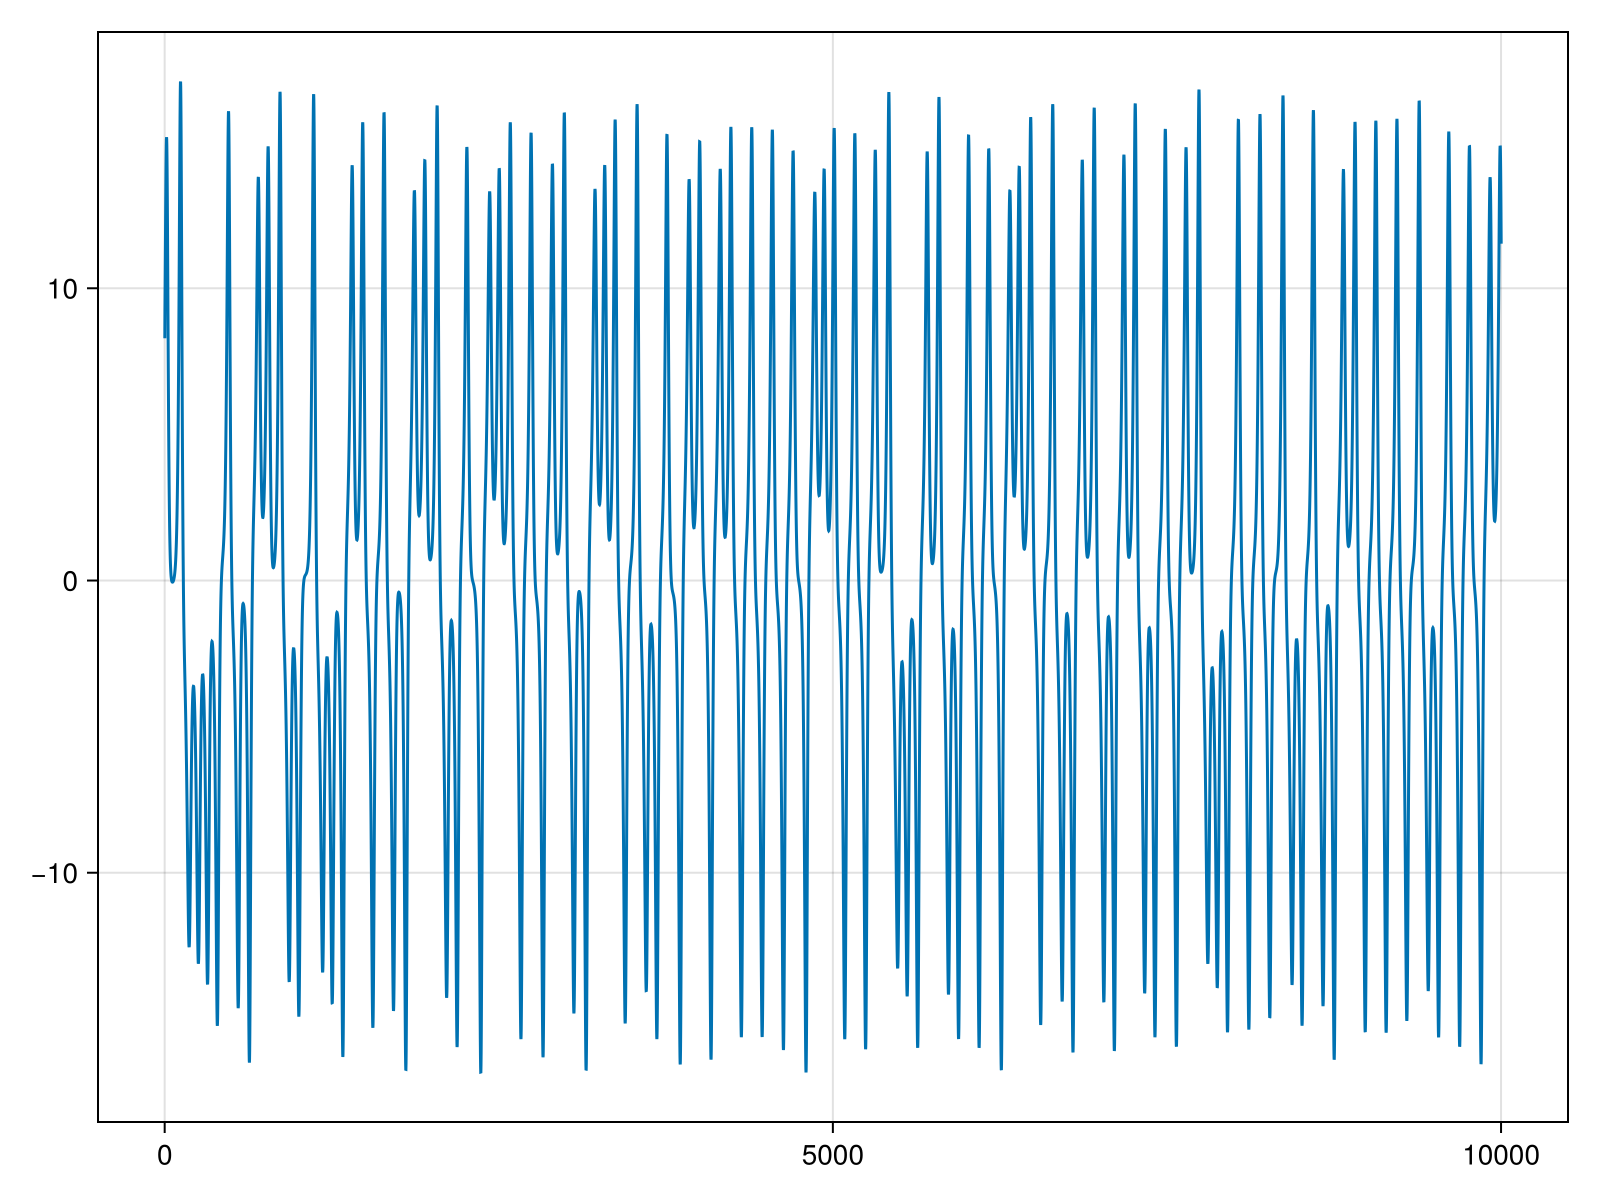

In [7]:
preds = create_pred_for_params_free_run(lo_train, 10000, 3; k = 100, testing_params=testing_params, α=0.2)
fig = quick_graph_series(preds)
# CairoMakie.save("readout_switching_freerun.pdf", fig)
fig

[2.0836866544056147, 3.128561037728171, 0.1692868799546841, -4.452919670555117, -0.5862084129069359, -1.6216172626970158, -4.012563411511421, 2.1346992687075907, -0.47761535913544667, -0.7711051915770357, 1.132666496349824, -1.5430016292533926, -4.936243441071494, -3.537091543457752, -2.3509625859971335, 2.0483251113069074, 6.723767779410147, -0.8092437527776981, -5.307577010482239, -1.984548449811664, 0.3960490058969573, 1.1409434618570078, 4.855950529258515, -1.215278960602432, 6.353639893152446, -1.33740928260342, -0.11428809494505993, -1.5080952593120485, 1.1386422960698488, -1.46554573979538, 0.08742243467335706, 2.796473049052132, -1.7260982779478626, -2.626922343455525, -0.9689098068130121, -2.0885175089020773, -1.4702747395883207, 0.0388815816806518, -2.0441882693465887, -6.9417216782524624, -3.9871684424065723, 3.8345804365460254, -2.6024058776326093, -1.0190019300265722, -0.3267522864287365, 5.453430883170719, 0.8325320342424826, 4.859270593940758, 2.2195465654272044, 2.39703

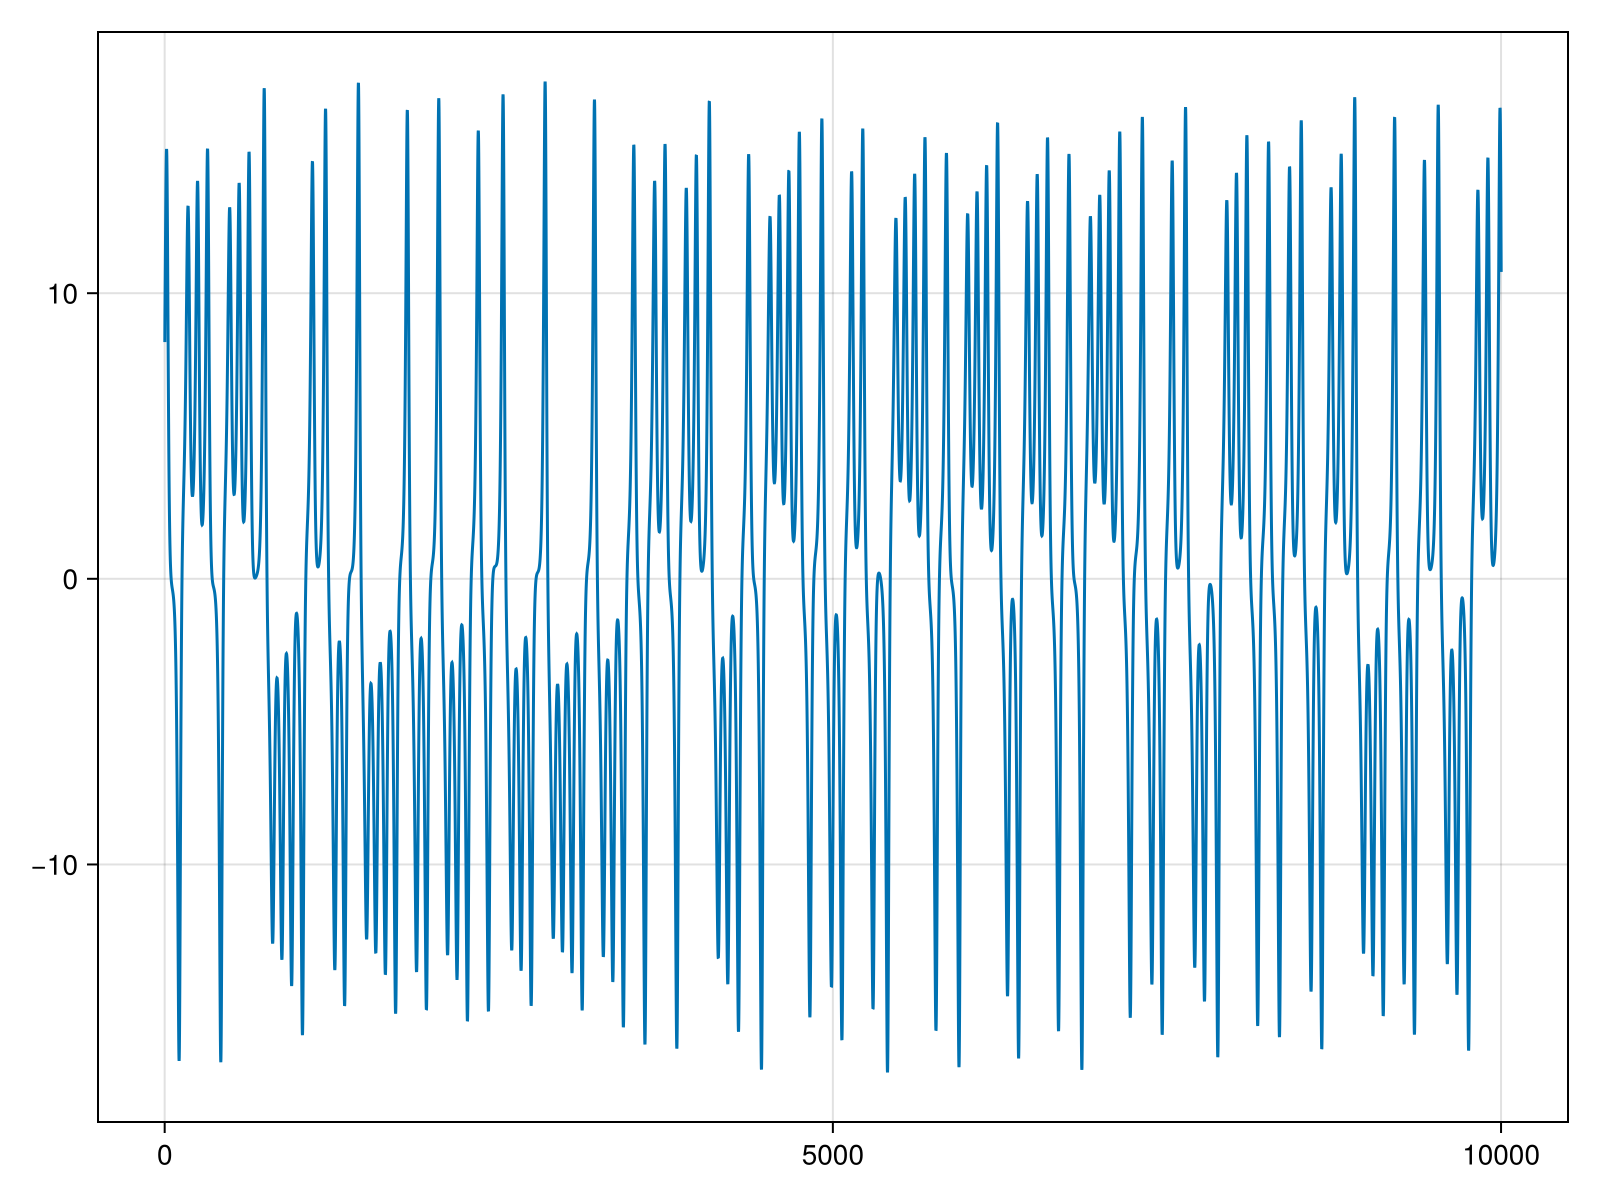

In [13]:
vanilla_preds = create_pred_for_params_free_run(lo_train, 10000, 1; k = 600, testing_params=testing_params, α = 0.2)
fig = quick_graph_series(vanilla_preds)
# CairoMakie.save("readout_switching_freerun.pdf", fig)
fig

In [9]:
function PlotAxis(fig, num, data, color, title, xlabel, ylabel, zlabel, azimuth)
    ax = Axis3(fig[1,num], title = title)

    lines!(
        ax, data[:,1], data[:,2], data[:,3];
        linewidth = 1.0,
        color = color)
    ax.xlabel = xlabel
    ax.ylabel = ylabel
    ax.zlabel = zlabel
    ax.azimuth = azimuth
end

function PlotOriginalAndReconstructed(tr, Y_mt, τ_vals_mt, ts_vals_mt, file_name, azimuth)
    println("Plotting original and reconstructed")

    ts_str = ["x", "y", "z"]

    fig = Figure(size = (1000,500) )

    PlotAxis(fig, 1, tr, Cycled(1),
        "original", "x(t)", "y(t)", "z(t)", π/2 + π/4)

    PlotAxis(fig, 2, Y_mt, Cycled(2),
        "PECUZAL reconstructed",
        "$(ts_str[ts_vals_mt[1]])(t+$(τ_vals_mt[1]))",
        "$(ts_str[ts_vals_mt[2]])(t+$(τ_vals_mt[2]))",
        "$(ts_str[ts_vals_mt[3]])(t+$(τ_vals_mt[3]))",
        azimuth)

#     CairoMakie.save(file_name, fig)
    return fig
end

PlotOriginalAndReconstructed (generic function with 1 method)

Initializing PECUZAL algorithm for univariate input...
Starting 1-th embedding cycle...
Starting 2-th embedding cycle...
Starting 3-th embedding cycle...
Algorithm stopped due to increasing L-values. VALID embedding achieved ✓.
Optimal computed τ: 9
Optimal computed M: 1
Plotting original and reconstructed


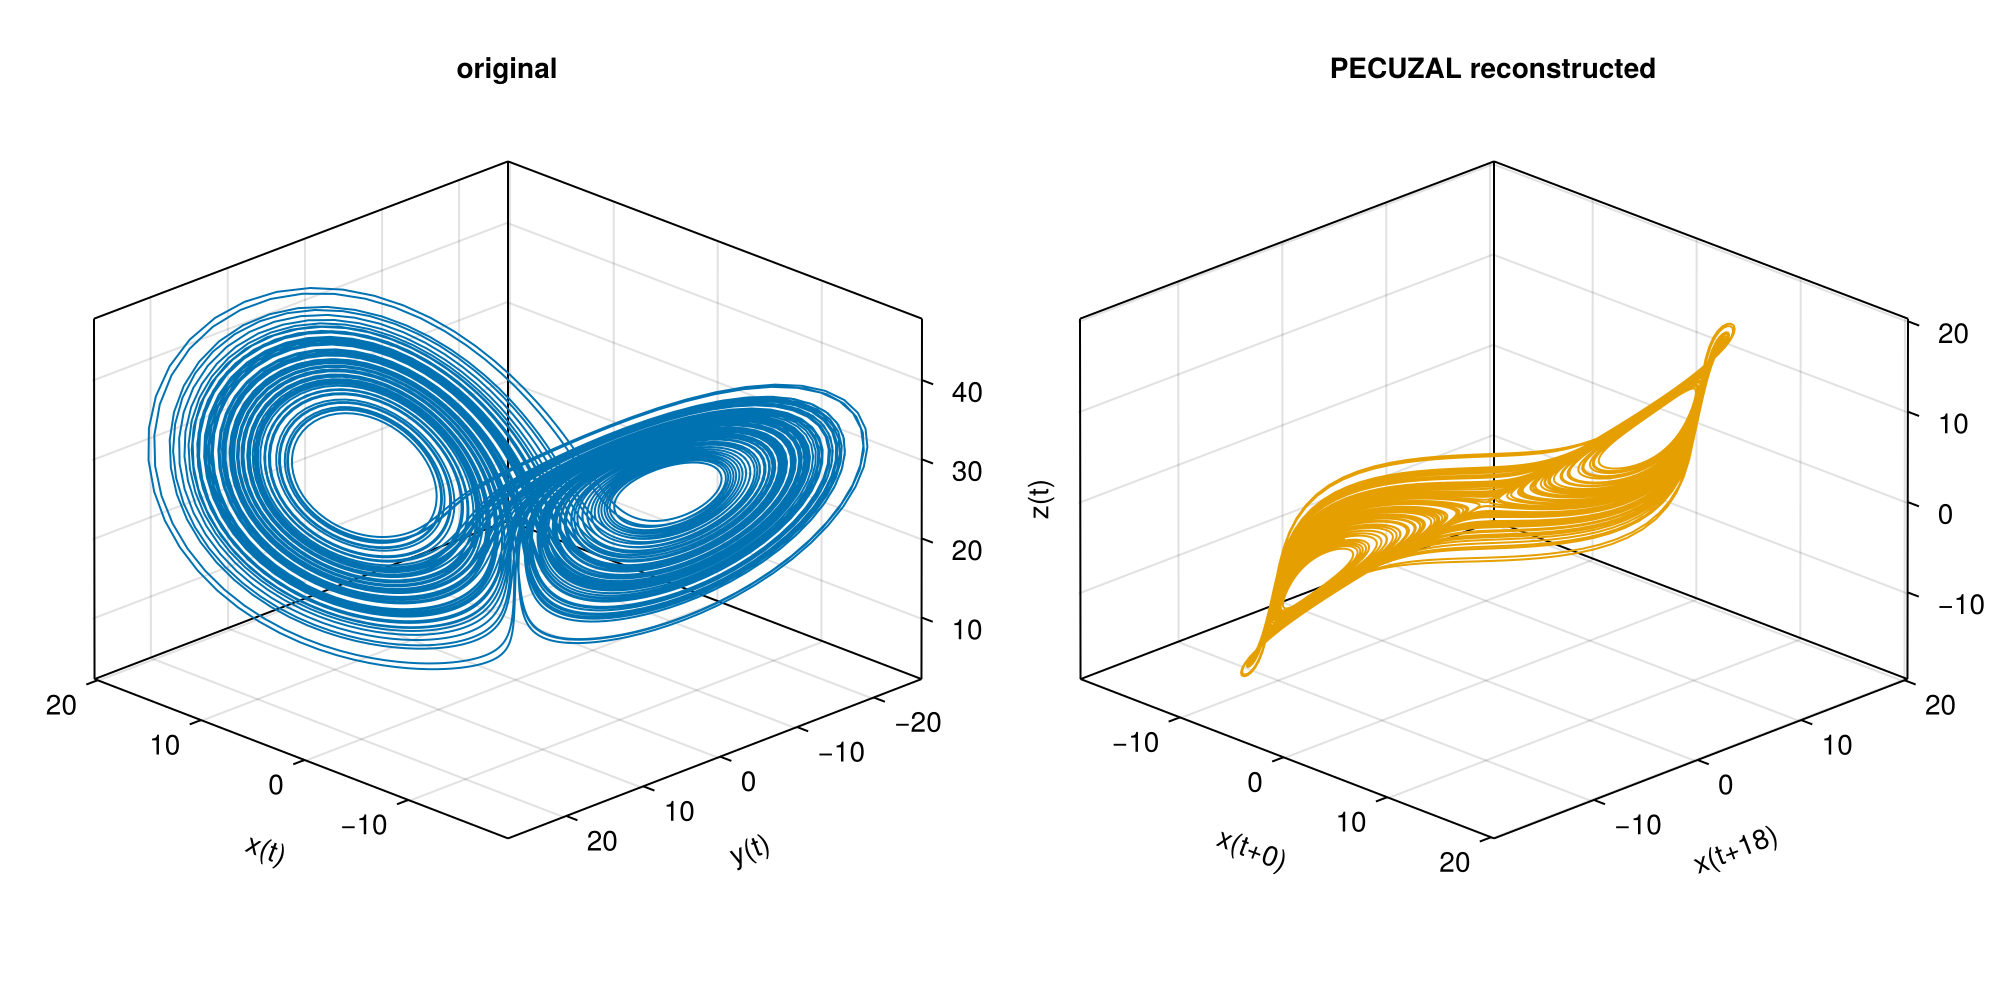

In [10]:
Tmax = 100

Y_mt, τ_vals_mt, ts_vals_mt, Ls_mt, εs_mt = pecuzal_embedding(
    lo_test;
    τs = 0:Tmax, L_threshold = 0.2
)

println("Optimal computed τ: ", τ_vals_mt[length(τ_vals_mt)])
println("Optimal computed M: ", ts_vals_mt[length(ts_vals_mt)])

PlotOriginalAndReconstructed(lo_tr_test, Y_mt, τ_vals_mt, ts_vals_mt,
    "test_embedding.png", 1.75*π)

Initializing PECUZAL algorithm for univariate input...
Starting 1-th embedding cycle...
Starting 2-th embedding cycle...
Starting 3-th embedding cycle...
Algorithm stopped due to increasing L-values. VALID embedding achieved ✓.
Optimal computed τ: 10
Optimal computed M: 1
Plotting original and reconstructed


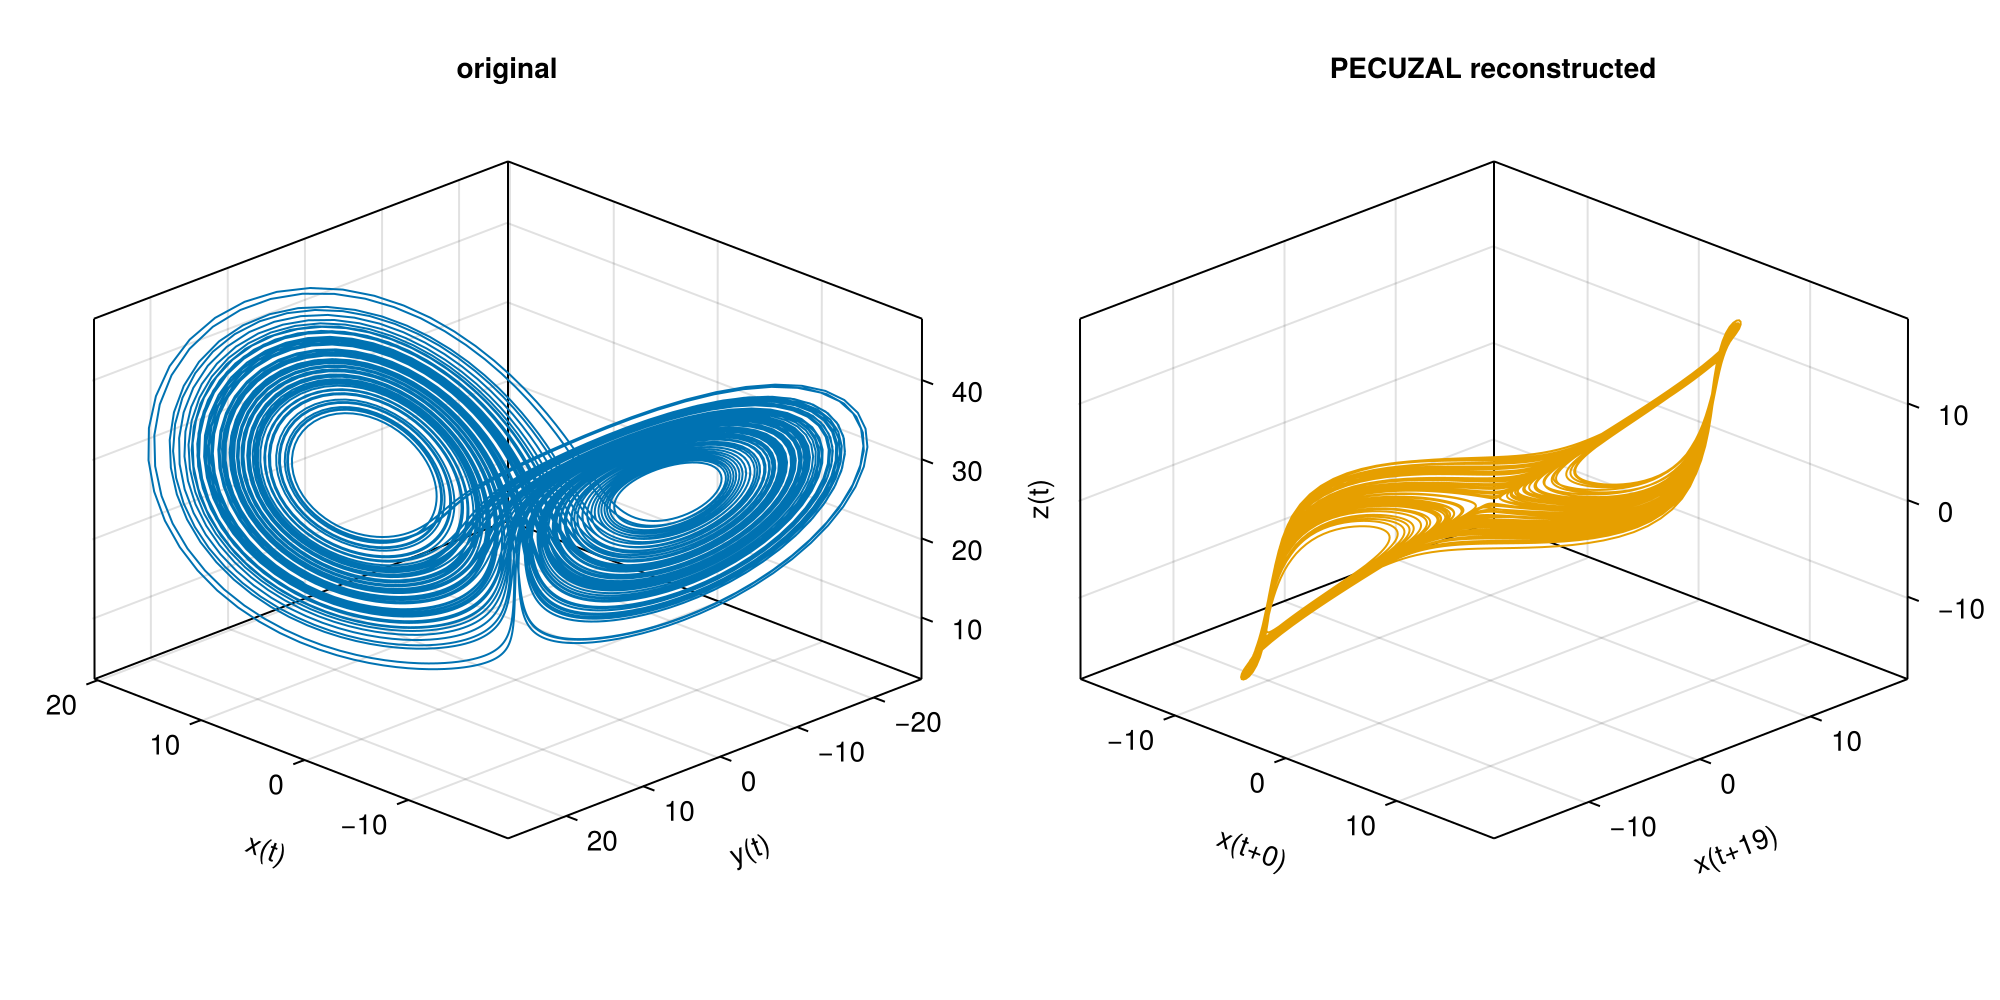

In [11]:
Y_mt, τ_vals_mt, ts_vals_mt, Ls_mt, εs_mt = pecuzal_embedding(
    Vector{Float64}(preds[100:end]);
    τs = 0:Tmax, L_threshold = 0.2
)

println("Optimal computed τ: ", τ_vals_mt[length(τ_vals_mt)])
println("Optimal computed M: ", ts_vals_mt[length(ts_vals_mt)])

PlotOriginalAndReconstructed(lo_tr_test, Y_mt, τ_vals_mt, ts_vals_mt,
    "test_embedding.png", 1.75*π)

Initializing PECUZAL algorithm for univariate input...
Starting 1-th embedding cycle...
Starting 2-th embedding cycle...
Starting 3-th embedding cycle...
Algorithm stopped due to increasing L-values. VALID embedding achieved ✓.
Optimal computed τ: 9
Optimal computed M: 1
Plotting original and reconstructed


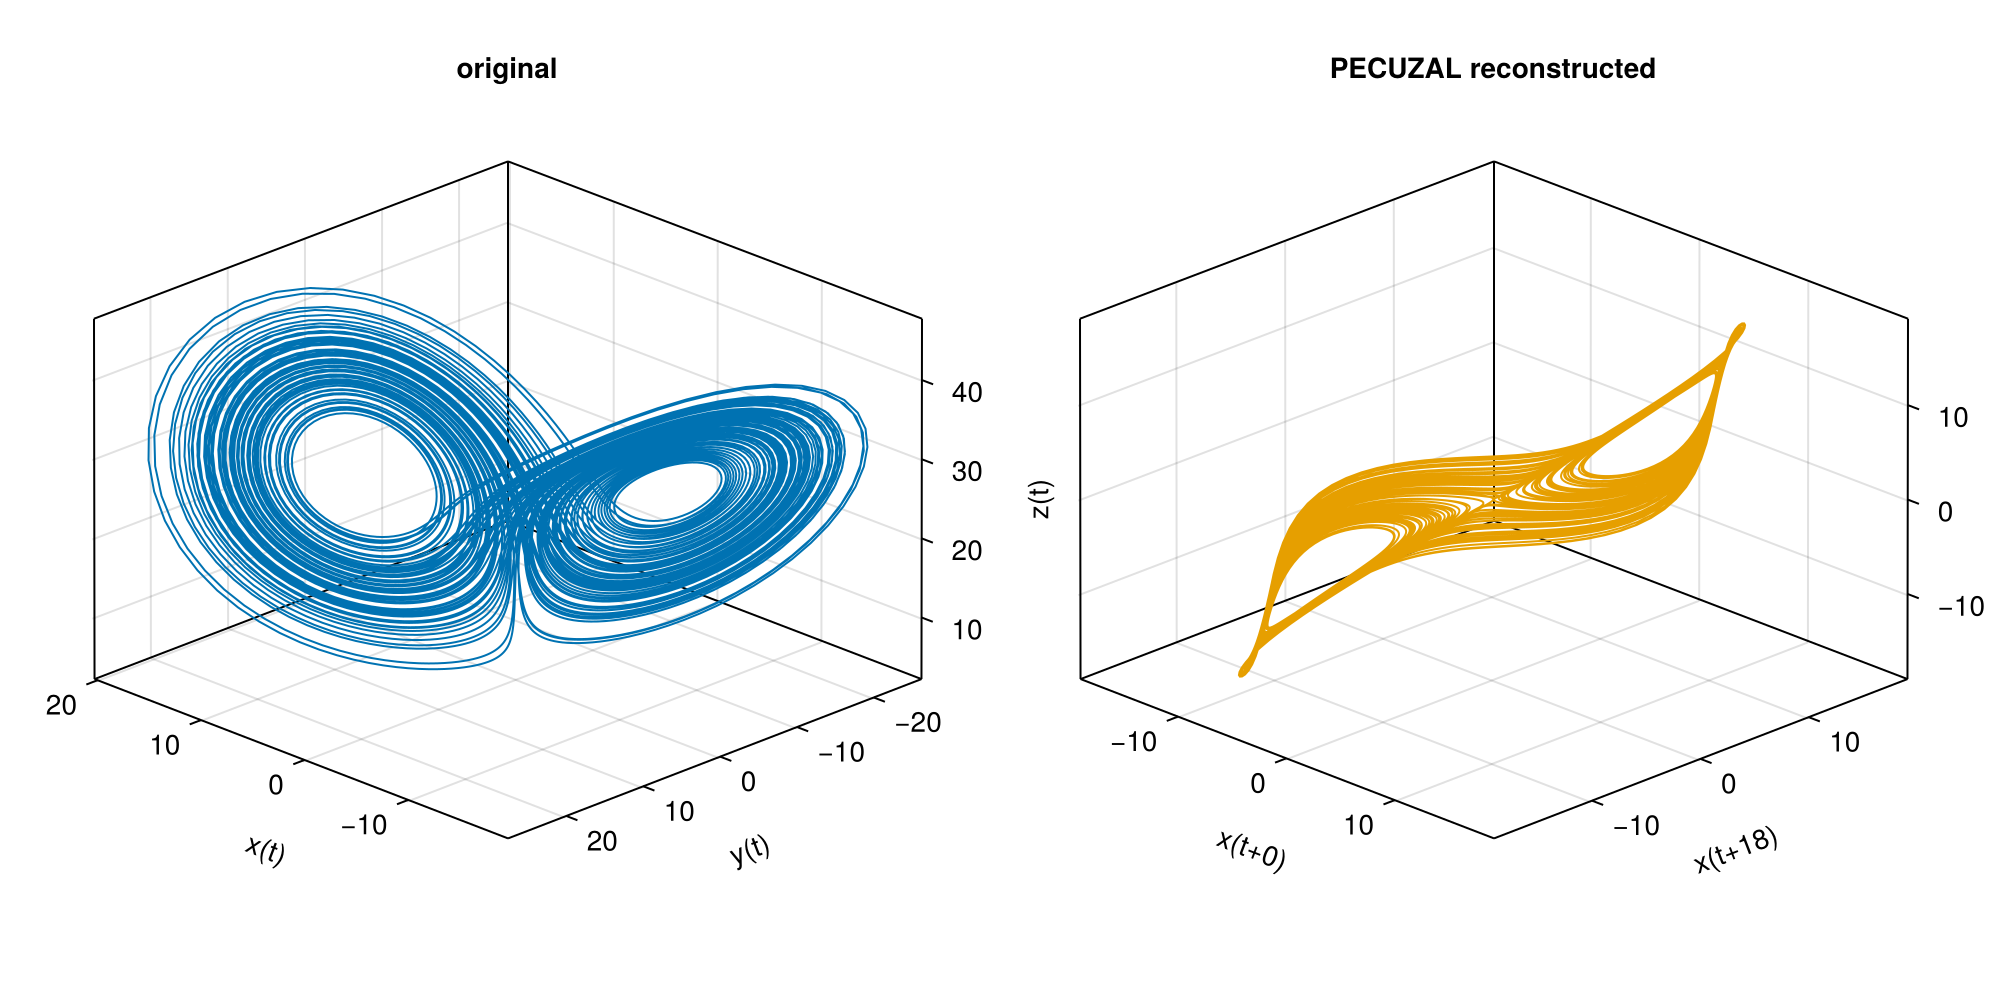

In [14]:
Y_mt, τ_vals_mt, ts_vals_mt, Ls_mt, εs_mt = pecuzal_embedding(
    Vector{Float64}(vanilla_preds[100:end]);
    τs = 0:Tmax, L_threshold = 0.2
)

println("Optimal computed τ: ", τ_vals_mt[length(τ_vals_mt)])
println("Optimal computed M: ", ts_vals_mt[length(ts_vals_mt)])

PlotOriginalAndReconstructed(lo_tr_test, Y_mt, τ_vals_mt, ts_vals_mt,
    "test_embedding.png", 1.75*π)